# Extended Data Fig. 3
- This experiment tests whether the observed (putative) HD cell bumps move as fish make turns, even without visual feedback of rotation
- The experiment start with open-loop presentaiton of flashes and optic flow
    - We reject cells that responded reliably to these stimuli
- Next, we present visual scenes so we can identify HD cells. Finally, we present side-stepping translational optic flow that disappears as fish swims.
- This notebook generates panels for **Extended Data Fig. 3c-f**.

In [1]:
from utility import *
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import flammkuchen as fl
from scipy.stats import wilcoxon
from scipy.signal import convolve2d
import json
from tqdm import tqdm
import colorcet as cc

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# configure matplotlib
config_rcparams()

In [3]:
## Analysis parameters

# ROI selection criteira
R2_thresh = 0.15
probe_thresh = 0.1

# binning of HD cells
n_heading_bin = 8

# bout related
min_bout_dt = 5 # we only consider bouts separated from each other by this many seconds
nan_thresh = 0.1 # we ignore bouts with this many failed tail tracking frames
deg_thresh = 2.0*np.pi / 3.0 # we rejects bouts bigger than this many radian

mask_name = 'rhombomere1'

# define relevant time windows
dur_bout_pre = 1
dur_bout_post = 2.1
probe_duration = 8
probe_rep = 5

In [10]:
# get a list of fish
data_path = '../data/ed03'
fish_list = get_fish_list(data_path, silent=True)

# because in this experiment we made multiple recordings from a single fish, we need
# a nested analysis
nested_list = nest_fish_list_per_fish(fish_list)

# Analysis
## Data extraction and ROI selection
- loop through the recordings, load data
- register relevant behavioral/physiological data into dict

In [12]:
data = []

# Go through all unique fish
for fish_id, recording_list in enumerate(nested_list):
    data.append([])
    
    # Go through all recordings
    for recording in recording_list:
        # If this particular recordings has a required mask, we analyze it
        mask_list = list(recording.glob('mask_'+mask_name+'*'))
        with open(mask_list[-1], 'r') as f:
            mask = json.load(f)
        
        #################
        ### Load data ###
        #################
        
        s2p_data, t_i, exp = load_data(recording, cells_only=False)
        roi_coords = s2p_data['coords']
        slog = exp['stimulus']['log']
        t_s = exp.stimulus_log['t'].to_numpy()
        theta = exp.stimulus_log['cl2D_theta'].to_numpy()
        theta_i = downsample_traces(t_s, theta, t_i)
        
        # restrict rois by mask (do this before functional selection to reduce the time-consuming nonlinear curve fitting)
        in_mask = (roi_coords[:, 2] > mask['x0']) * (roi_coords[:, 2] < mask['x1']) * (roi_coords[:, 1] > mask['y0']) * (roi_coords[:, 1] < mask['y1'])
        traces = s2p_data['traces'][in_mask,:len(t_i)]
        norm_traces = ((traces.T - np.median(traces, axis=1))/np.std(traces, axis=1)).T
        smoothed_traces = convolve2d(norm_traces, np.ones((1,5))/5, mode='same')
        roi_coords = roi_coords[in_mask, :]
        n_roi = traces.shape[0]
        
        #####################
        ### ROI selection ###
        #####################
        
        # Reject ROI with high flash and optic flow correlation
        flash_t_start = [epoch['t_start'] for epoch in slog[1:2*probe_rep:2]] # first epoch is wait, last two epochs are sun-and-bars and darkness. 
        of_t_start = [epoch['t_start'] for epoch in slog[11:4*probe_rep:2]] 
        flash_corr = calc_snip_correlation(norm_traces, t_i, flash_t_start, probe_duration)
        of_corr = calc_snip_correlation(norm_traces, t_i, of_t_start, probe_duration)

        # Sinusoidal regression -- use the entire first epoch
        is_valid_theta = (np.isnan(theta_i)==False) * (t_i < slog[-1]['t_start'])
        fit_param, _, R2 = fit_transform_sinusoid(smoothed_traces[:, is_valid_theta], theta_i[is_valid_theta])
        
        # do the selection
        good_fit = (R2 > R2_thresh) * (flash_corr < probe_thresh) * (of_corr < probe_thresh)
        print(recording, 'Found', np.sum(good_fit), 'good ROIs out of', n_roi )
        
        ### Save everything in a dictionary ###
        D = {'stack': s2p_data['anatomy_stack'][0,:,:],
             'slog': slog,
             't_s': t_s,
             't_b': exp.behavior_log['t'].to_numpy(),
             'fish_theta': exp.stimulus_log['cl2D_fish_theta'].to_numpy(),
             'theta_update_spike': exp.stimulus_log['cl2D_start_theta_update'].to_numpy(),
             'tail_sum': exp.behavior_log['tail_sum'].to_numpy(),
             'star_direction': exp.stimulus_log['cl2D_starfield_direction'].to_numpy(),
             't_i': t_i,
             'theta_i': theta_i,
             'traces': smoothed_traces[good_fit, :],
             'fit_param': fit_param[good_fit,:],
             'coords': roi_coords[good_fit, :]}
        data[-1].append(D)

..\data\ed03\20231205_f0_v8_fixed Found 11 good ROIs out of 164
..\data\ed03\20231205_f1_v8 Found 9 good ROIs out of 125
..\data\ed03\20231205_f2_v8 Found 5 good ROIs out of 154
..\data\ed03\20231205_f3_v8 Found 22 good ROIs out of 131
..\data\ed03\20231206_f0_v8 Found 33 good ROIs out of 163
..\data\ed03\20231206_f1_v8 Found 7 good ROIs out of 157
..\data\ed03\20231206_f2_v8 Found 13 good ROIs out of 136
..\data\ed03\20231206_f3_v8 Found 14 good ROIs out of 124
..\data\ed03\20231206_f4_v8 Found 1 good ROIs out of 130
..\data\ed03\20231206_f5_v8 Found 15 good ROIs out of 151
..\data\ed03\20231206_f6_v8 Found 0 good ROIs out of 106
..\data\ed03\20231207_f0_v8 Found 22 good ROIs out of 136
..\data\ed03\20231207_f1_v8 Found 3 good ROIs out of 130
..\data\ed03\20231207_f2_v8 Found 35 good ROIs out of 166
..\data\ed03\20231207_f3_v8 Found 15 good ROIs out of 127
..\data\ed03\20231207_f4_v8 Found 18 good ROIs out of 122
..\data\ed03\20231207_f5_v8 Found 32 good ROIs out of 139
..\data\ed03\2

## Additional recording-wise analysis

In [13]:
for i, fish_data in enumerate(data):
    for j, D in enumerate(fish_data):
        
        # Calculate "bump phase" (population vector average angle) with binning
        pva_theta, pva_length, binned_traces, _, _ = calc_binned_pva(D['traces'], D['fit_param'][:,1], n_bin=n_heading_bin)
        data[i][j]['pva_theta'] = pva_theta
        data[i][j]['pva_length'] = pva_length
        data[i][j]['binned_traces'] = binned_traces
        n_empty_bin = np.sum(np.isnan(binned_traces[:, 0]))
        
        ### Bias-bump phase change correlation in the sidestep epoch ###
        # First get bias (don't take one too close to the end of the experiment)
        bout_ind_dark = np.where(D['theta_update_spike'] * (D['t_s']>D['slog'][-1]['t_start']) * (D['t_s']<max(D['t_s'])-dur_bout_post))[0]
        t_bout_dark = D['t_s'][bout_ind_dark]
        bias_dark = D['fish_theta'][bout_ind_dark]
        
        # Only keep isoldated, not-too-big ones without too many NaNs
        dt_bout_dark = np.diff(t_bout_dark)
        is_isolated = np.append(True, dt_bout_dark>min_bout_dt) * np.append(dt_bout_dark>min_bout_dt, True)
        
        nan_frac = []
        for t in t_bout_dark:
            inds = (D['t_b']>=t - 0.07) * (D['t_b']<t)
            nan_frac.append(np.mean(np.isnan(D['tail_sum'][inds])))
        nan_frac = np.asarray(nan_frac)

        not_too_big = (np.abs(bias_dark)<deg_thresh)
        good_tracked = (nan_frac < nan_thresh)
        good_bout = is_isolated * not_too_big * good_tracked
        
        print('Fish {0}-{1}, empty bin {2}, total {3}, selected {4} bouts'.format(
               i, j, n_empty_bin,
               len(good_bout), 
               np.sum(good_bout)))
        
        # We only consider recordings that had more than 5 good bouts & less than 5 empty bins
        good_rec_flag = (n_empty_bin<5) * (np.sum(good_bout)>5)
        data[i][j]['good_rec_flag'] = good_rec_flag
        
        # Get neural heading snip & calculate correlation / slope
        if good_rec_flag:
            peri_dark_bout_pva_angle, t_snip = cut_snip(np.unwrap(pva_theta), D['t_i'], t_bout_dark[good_bout], dur_bout_pre, dur_bout_post)
            pva_at_the_snip_end = np.mean(peri_dark_bout_pva_angle[:,t_snip>(dur_bout_post-1)], axis=1)
            C = np.corrcoef(bias_dark[good_bout], pva_at_the_snip_end)
            b = np.linalg.lstsq(bias_dark[good_bout][:,None], pva_at_the_snip_end)[0]
            data[i][j]['bias_good_bout'] = bias_dark[good_bout]
            data[i][j]['peri_bout_pva'] = peri_dark_bout_pva_angle
            data[i][j]['bias_pva_correlation'] = C[0,1]
            data[i][j]['bias_pva_slope'] = b[0] 
        else:
            data[i][j]['bias_good_bout'] = np.nan
            data[i][j]['peri_bout_pva'] = np.nan
            data[i][j]['bias_pva_correlation'] = np.nan
            data[i][j]['bias_pva_slope'] = np.nan
            
        # Quality measures (in the end we are not using this)
        vr_pva_offset = angular_diff(D['theta_i'], pva_theta)
        is_stonehenge = (D['t_i']>D['slog'][-2]['t_start']) * (D['t_i']<D['slog'][-1]['t_start'])
        data[i][j]['mean_absolute_offset'] = np.nanmean(np.abs(vr_pva_offset[is_stonehenge]))
        data[i][j]['n_good_cells'] = D['fit_param'].shape[0]
        data[i][j]['mean_tuning_length'] = np.sqrt(np.mean(np.cos(D['fit_param'][:,1]))**2 + np.mean(np.sin(D['fit_param'][:,1]))**2)
        data[i][j]['n_good_bouts'] = np.sum(good_bout)

Fish 0-0, empty bin 4, total 206, selected 31 bouts
Fish 1-0, empty bin 5, total 152, selected 31 bouts


C:\Users\ryosuke\AppData\Local\Temp\ipykernel_18792\289450751.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(bias_dark[good_bout][:,None], pva_at_the_snip_end)[0]


Fish 2-0, empty bin 5, total 126, selected 30 bouts
Fish 3-0, empty bin 4, total 105, selected 22 bouts
Fish 4-0, empty bin 1, total 68, selected 40 bouts
Fish 5-0, empty bin 5, total 77, selected 41 bouts
Fish 6-0, empty bin 3, total 140, selected 34 bouts
Fish 7-0, empty bin 4, total 137, selected 33 bouts
Fish 8-0, empty bin 7, total 130, selected 20 bouts
Fish 9-0, empty bin 3, total 84, selected 26 bouts
Fish 10-0, empty bin 8, total 36, selected 13 bouts
Fish 11-0, empty bin 3, total 39, selected 15 bouts
Fish 12-0, empty bin 6, total 49, selected 38 bouts
Fish 13-0, empty bin 0, total 105, selected 50 bouts


C:\Users\ryosuke\Documents\manuscripts\landmark\code_public\notebooks\utility.py:221: RuntimeWarning: invalid value encountered in divide
  PVA /= len(np.unique(phi_ind))
C:\Users\ryosuke\AppData\Local\Temp\ipykernel_18792\289450751.py:59: RuntimeWarning: Mean of empty slice
  data[i][j]['mean_absolute_offset'] = np.nanmean(np.abs(vr_pva_offset[is_stonehenge]))
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Fish 14-0, empty bin 1, total 47, selected 31 bouts
Fish 15-0, empty bin 2, total 85, selected 54 bouts
Fish 16-0, empty bin 2, total 43, selected 20 bouts
Fish 17-0, empty bin 5, total 117, selected 39 bouts
Fish 18-0, empty bin 8, total 53, selected 7 bouts
Fish 19-0, empty bin 4, total 86, selected 35 bouts
Fish 19-1, empty bin 7, total 74, selected 26 bouts
Fish 20-0, empty bin 8, total 43, selected 1 bouts
Fish 20-1, empty bin 8, total 46, selected 0 bouts
Fish 21-0, empty bin 3, total 123, selected 35 bouts
Fish 21-1, empty bin 3, total 41, selected 21 bouts
Fish 22-0, empty bin 7, total 66, selected 9 bouts
Fish 22-1, empty bin 8, total 62, selected 6 bouts
Fish 23-0, empty bin 5, total 112, selected 42 bouts
Fish 23-1, empty bin 5, total 142, selected 47 bouts
Fish 24-0, empty bin 5, total 26, selected 3 bouts
Fish 25-0, empty bin 4, total 87, selected 40 bouts
Fish 26-0, empty bin 5, total 62, selected 12 bouts
Fish 27-0, empty bin 0, total 58, selected 50 bouts
Fish 28-0, emp

# Panels
## Extended Data Fig. 3c (individual example)

In [14]:
# Define the recording to look at
fid = 16
rid = 0
D = data[fid][rid]

In [15]:
# visualization parameters
max_bias = np.pi/4
bias_thresh = 0.2

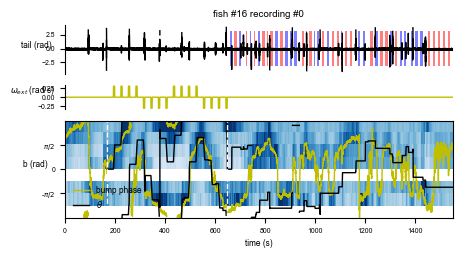

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(5,2.5), height_ratios=(2,1,4))

## Behavioral time trace
# Figure out optic flow directions
star_on = np.abs(D['star_direction'])
t_star_onset = [D['t_s'][i] for i in np.where(np.diff(star_on)==1)[0]]
t_star_offset = [D['t_s'][i] for i in np.where(np.diff(star_on)==-1)[0] if D['t_s'][i]<max(t_i)]
star_direction = [D['star_direction'][i+1] for i in np.where(np.diff(star_on)==1)[0]]

# plot optic flow direction
for ton, toff, sign in zip(t_star_onset, t_star_offset, star_direction):
    ax[0].fill_between([ton, toff],[-np.pi, -np.pi],[np.pi, np.pi],edgecolor='none', facecolor=((1+sign)/2, 0, -(sign-1)/2), alpha=0.5, zorder=-10)

# tail trace
ax[0].plot(D['t_b'], D['tail_sum'], label='tail sum', lw=1, color='black')

# axis management
ax[0].set_xlim(0, max(t_i))
ax[0].set_ylabel('tail (rad)', rotation=0)
ax[0].set_title('fish #{} recording #{}'.format(fid,rid))
toggle_spines(ax[0],0,0,0,1)

## visualize external rotation
t_start = D['slog'][-2]['t_start']
t_end = D['slog'][-1]['t_start']
OL_on = (((D['t_i']-t_start)%30)>25) * (D['t_i']>t_start) * (D['t_i']<t_end)
OL_sign = 1-2*(((D['t_i']-t_start)%240)>120)
ax[1].plot(D['t_i'], OL_on*OL_sign*18/180*np.pi,'y-')
ax[1].set_xlim(0, max(t_i))
ax[1].set_ylabel(r'$\omega_{ext}$ (rad/s)',rotation=0)
toggle_spines(ax[1],0,0,0,1)

## Neural time trace (heatmap)
ax[2].imshow(D['binned_traces'][::-1, :], aspect='auto', interpolation='nearest', vmax=2, vmin=-2, extent=(0, max(D['t_i']), -np.pi, np.pi), cmap='Blues')
ax[2].plot(D['t_i'], wrapped(np.unwrap(D['pva_theta']), offset=np.pi), 'y-', linewidth=1, label='bump phase')
ax[2].plot(D['t_i'], wrapped(D['theta_i'], offset=np.pi), 'k-', linewidth=1, label=r'$\theta$')
for j in range(2):
    ax[2].plot((D['slog'][-j-1]['t_start'], D['slog'][-j-1]['t_start']),(-np.pi,np.pi),'w--')
ax[2].set_yticks([-np.pi/2, 0, np.pi/2])
ax[2].set_yticklabels((r'-$\pi/2$', '0', r'$\pi/2$'))
ax[2].set_ylabel('b (rad)', rotation=0)
ax[2].set_xlabel('time (s)')
ax[2].legend()

plt.savefig('../svg/ed03_c.svg')
plt.show()

## Extended Data Fig. 3d, e (bump phase change at each bout)

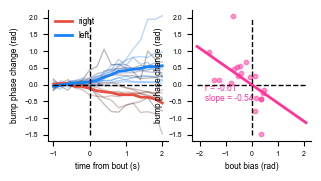

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(3.4,1.7))

## Bump phase change time trace around bouts
# individual bout, color coded by bias
for this_bias, this_pva in zip(D['bias_good_bout'], D['peri_bout_pva']):
    norm_bias = (max(-1, min(+1, (this_bias / max_bias)))+1)/2
    ax[0].plot(t_snip, this_pva, color=cc.cm.CET_D4(norm_bias), alpha=0.3, lw=1)
    
# calculate average by directions, and plot
mean_right = np.mean(D['peri_bout_pva'][D['bias_good_bout']>bias_thresh, :], axis=0)
mean_left = np.mean(D['peri_bout_pva'][D['bias_good_bout']<-bias_thresh, :], axis=0)
ax[0].plot(t_snip, mean_right, color=cc.cm.CET_D4(1.0), lw=2, label='right')
ax[0].plot(t_snip, mean_left, color=cc.cm.CET_D4(0.0), lw=2, label='left')

# axis management
ax[0].plot(t_snip, 0*t_snip, 'k--')
ax[0].plot((0,0), (-1.5,2), 'k--')
ax[0].legend()
ax[0].set_xlabel('time from bout (s)')
ax[0].set_ylabel('bump phase change (rad)')
toggle_spines(ax[0],0,1,0,1)

## Bump phase change vs bias scatter (with regression line)
ax[1].scatter(D['bias_good_bout'], D['peri_bout_pva'][:, -1], s= 10, color=color_getter(0), alpha=0.5)
ax[1].plot((-deg_thresh,deg_thresh),(0,0),'k--')
ax[1].plot((-deg_thresh,deg_thresh), (-deg_thresh*D['bias_pva_slope'], deg_thresh*D['bias_pva_slope']), lw=2, color=color_getter(0))
ax[1].plot((0,0),(-1.5,2),'k--')
ax[1].text(-1.8, -0.5,'r = {:0.2}\nslope = {:0.2}'.format(D['bias_pva_correlation'], D['bias_pva_slope']), color=color_getter(0))
ax[1].set_xlabel('bout bias (rad)')
ax[1].set_ylabel('bump phase change (rad)')
toggle_spines(ax[1],0,1,0,1)

plt.savefig('../svg/ed03_de.svg')
plt.show()

## Extended Data Fig. 3f (population plot of slope and correlation)
- There is only one fish that had two good recordings. I will just arithmetically average the results from the two planes.

In [19]:
# concatenate correlation and slope across fish

all_r = []
all_b = []
for i, fish_data in enumerate(data):
    this_r = []
    this_b = []
    for j, D in enumerate(fish_data):
        if D['good_rec_flag']:
            this_r.append(D['bias_pva_correlation'])
            this_b.append(D['bias_pva_slope'])
    all_r.append(np.nanmean(this_r))
    all_b.append(np.nanmean(this_b))
    
all_r = np.asarray(all_r)
all_b = np.asarray(all_b)

C:\Users\ryosuke\AppData\Local\Temp\ipykernel_18792\2137177570.py:12: RuntimeWarning: Mean of empty slice
  all_r.append(np.nanmean(this_r))
C:\Users\ryosuke\AppData\Local\Temp\ipykernel_18792\2137177570.py:13: RuntimeWarning: Mean of empty slice
  all_b.append(np.nanmean(this_b))


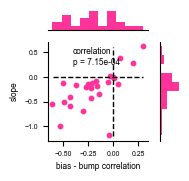

In [23]:
fig, ax = plt.subplots(2,2,figsize=(1.7, 1.7), height_ratios=(1,5), width_ratios=(5,1))

# correation vs. slope scatter
ax[1,0].scatter(all_r, all_b, color=color_getter(0), s=10)
ax[1,0].plot((-0.6,0.3),(0,0),'k--')
ax[1,0].plot((0,0),(-1.2,0.6),'k--')
ax[1,0].set_xlabel('bias - bump correlation')
ax[1,0].set_ylabel('slope')

# Marginal distributions
ax[0,0].hist(all_r, color=color_getter(0))
ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].hist(all_b, orientation='horizontal', color=color_getter(0))
ax[1,1].set_ylim(ax[1,0].get_ylim())

# general axis pretiffication
toggle_spines(ax[1,0],0,1,0,1)
toggle_spines(ax[0,0],0,1,0,0)
toggle_spines(ax[1,1],0,0,0,1)
toggle_spines(ax[0,1],0,0,0,0)
ax[0,0].set_xticks([])
ax[1,1].set_yticks([])

# stats
_, p = wilcoxon(all_r[~np.isnan(all_r)])
ax[1,0].text(-0.4, 0.25, 'correlation\np = {:0.2e}'.format(p))

plt.savefig('../svg/ed03_f.svg')
plt.show()